In [ ]:
%load_ext autoreload
%autoreload 2
#---------------------------Imports-------------------------------------------
import numpy as np
import pandas as pd
import os
import glob
import importlib
import matplotlib.pyplot as plt
import sys
import sympy as sp

# Add Help_functions directory to the system path - Kommer bli en del sånt nu framöver
sys.path.append(os.path.join(os.getcwd(), 'Help_functions'))

from Data_Cleaning_test import*

#----------------------------load_data delete ()-----------------------------------
folder_path = 'C:\\Users\\Master_Student\\ml\\Data\\data_oct_2023\\features\\'
df = import_and_combine_data(folder_path)
# Delete all parentheses in column names, this for PySRRegressor to work
df.columns = df.columns.str.replace(r'\(.*?\)', '', regex=True).str.strip()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
#---------------------------Fix Missing data-------------------------------------------
def fix_missing_data(group):
    # Interpolate
    group = group.interpolate(method='linear')
    # Forward fill
    group = group.ffill()
    # Backward fill
    group = group.bfill()
    return group

# Apply all operations in a single pass
grouped = df.groupby(['round', 'device'], group_keys=False)
df = grouped.apply(fix_missing_data)

df['swing_temperature'] = df['max_temperature'] - df['min_temperature'] 

#-----------------------------Abbrevations for plotting---------------------------------------------

temperature_columns = [
    'min_temperature', 
    'max_temperature', 
    'min_block_temperature_1', 
    'max_block_temperature_1', 
    'min_block_temperature_2', 
    'max_block_temperature_2', 
    'avg_max_block_temperature', 
    'min_water_inlet_temperature',
    'max_water_inlet_temperature', 
    'min_water_outlet_temperature', 
    'max_water_outlet_temperature', 
]
# Create the abbreviation dictionary for renaming the columns
abbreviations = {
    'cycle': 'Cyc',
    'consumed_life': 'CL',
    'end_voltage': 'V_end',
    'end_resistance': 'R_end',
    'end_resistance_residual': 'R_res',
    'end_resistance_residual_cleaned': 'R_res_cl',
    'min_temperature': 'T_min',
    'max_temperature': 'T_max',
    'min_block_temperature_1': 'T_B1_min',
    'max_block_temperature_1': 'T_B1_max',
    'min_block_temperature_2': 'T_B2_min',
    'max_block_temperature_2': 'T_B2_max',
    'avg_max_block_temperature': 'T_B_avg_max',
    'min_water_inlet_temperature': 'T_WI_min',
    'max_water_inlet_temperature': 'T_WI_max',
    'min_water_outlet_temperature': 'T_WO_min',
    'max_water_outlet_temperature': 'T_WO_max',
    'swing_temperature': 'T_Sw'
} 

columns_to_clean = ['end_voltage', 'end_resistance',
       'end_resistance_residual', 'end_resistance_residual_cleaned',
       'min_temperature', 'max_temperature', 'min_block_temperature_1',
       'max_block_temperature_1', 'min_block_temperature_2',
       'max_block_temperature_2', 'avg_max_block_temperature',
       'min_water_inlet_temperature', 'max_water_inlet_temperature',
       'min_water_outlet_temperature', 'max_water_outlet_temperature', 'swing_temperature'] # tar bort cycle!

# Function to replace column names with abbreviations
def get_abbreviation(column_name):
    return abbreviations.get(column_name, column_name)  # Use the abbreviation if it exists, otherwise use the original name



#---------------------------------------Get rid of unphyiscal temperature drops in the data---------------------------------------------------------------

#-----------------------------------------------Filtrera datan-----------------------------------------------------

# Rätta till device 1 in round 9
df = df[~((df['round'] == 9) & (df['device'] == 1) & (df['consumed_life'] > 0.985))]
# Filter data for device 1 in round 9
condition = (df['round'] == 9) & (df['device'] == 1)

# Calculate the new 'consumed_life' as the normalized 'cycle' for the remaining rows
df.loc[condition, 'consumed_life'] = (
    df.loc[condition, 'cycle'] / df.loc[condition, 'cycle'].max()
    
#--------------------------------------------------------------------------------    
)
devices = list(range(1,11)) # ska vara 11 här !
rounds = [8, 9]

segmented_data = make_segments(
    df=df,
    devices=devices,
    rounds=rounds,
    cut_at_CL_one=True,       # Remove rows with consumed_life > 1      # Minimum segment size to keep
    cycle_threshold=2000       # Remove rows with cycle < 500
)


filtered_data = exclude_transition_cycles(
    segmented_data=segmented_data, 
    transition_margin=100,  # Standard transition margin 75 förr
    filter_columns=columns_to_clean,
    verbose=True
)

merged_data, aligned_data = merge_segments(
    segmented_data=filtered_data,
    devices=devices,
    rounds=[8, 9],
    columns_to_merge= columns_to_clean,
    mean_interval_proportion=0.1, # 0.1
    min_interval=10,
    max_interval=500,
    transition_margin=10
)

#print(adjusted_segmented_data)
filled_merged_data, gap_statistics = fill_gaps(
   merged_data=merged_data,
   columns_to_fill=columns_to_clean,
    window_size= 1000
)

window_size = 250  

m_average_data = calculate_moving_averages(filled_merged_data, window_size)

convert_temperatures_to_kelvin(m_average_data, temperature_columns)

#--------------------------------------------Stratified sampling---------------------------------------------------------------------
with_initial_values = add_initial_values(m_average_data, verbose = True)

sampled_data_dict = systematic_sample_device_data(data_dict =with_initial_values, rounds = rounds, devices = devices, n_samples=300, verbose =True)

round_dict_un_sampled = devices_combined_into_one_df(with_initial_values , [8,9]) 
round_dict = devices_combined_into_one_df(sampled_data_dict , [8,9]) #--------------- bra

combined_df_unsampled = combine_all_rounds(round_dict_un_sampled)
combined_df = combine_all_rounds(round_dict)

C:\Users\Master_Student\AppData\Local\Temp\ipykernel_11308\2855514198.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = grouped.apply(fix_missing_data)


segment_devices_data:
Total rows removed: 66231.00 out of 1053366.00 (6.29%)
Rows removed due to consumed_life > 1: 26251.00
Rows removed due to cycle < 2000.00: 39980.00
----------------------------------------------------------------------------
exclude_transition_cycles:
Total rows marked as NaN: 24227.00 out of 987135.00 (2.45%)
Total individual NaN values marked: 387632.00
----------------------------------------------------------------------------
fill_gaps:
Total NaN values filled: 387,632 out of 15,794,160 values (2.45%)
Gap Statistics: Max=343.00, Min=102.00, Mean=212.52, Std=39.52, Total Gaps=1824.00
----------------------------------------------------------------------------
calculate_moving_averages
Total rows removed: 4980 out of 987135 (0.50%)
Expected rows removed due to window size (250): 4980.00
--------------------------------------------------------------------------------------------

Processing Round 8
------------------------------------------------------------

D

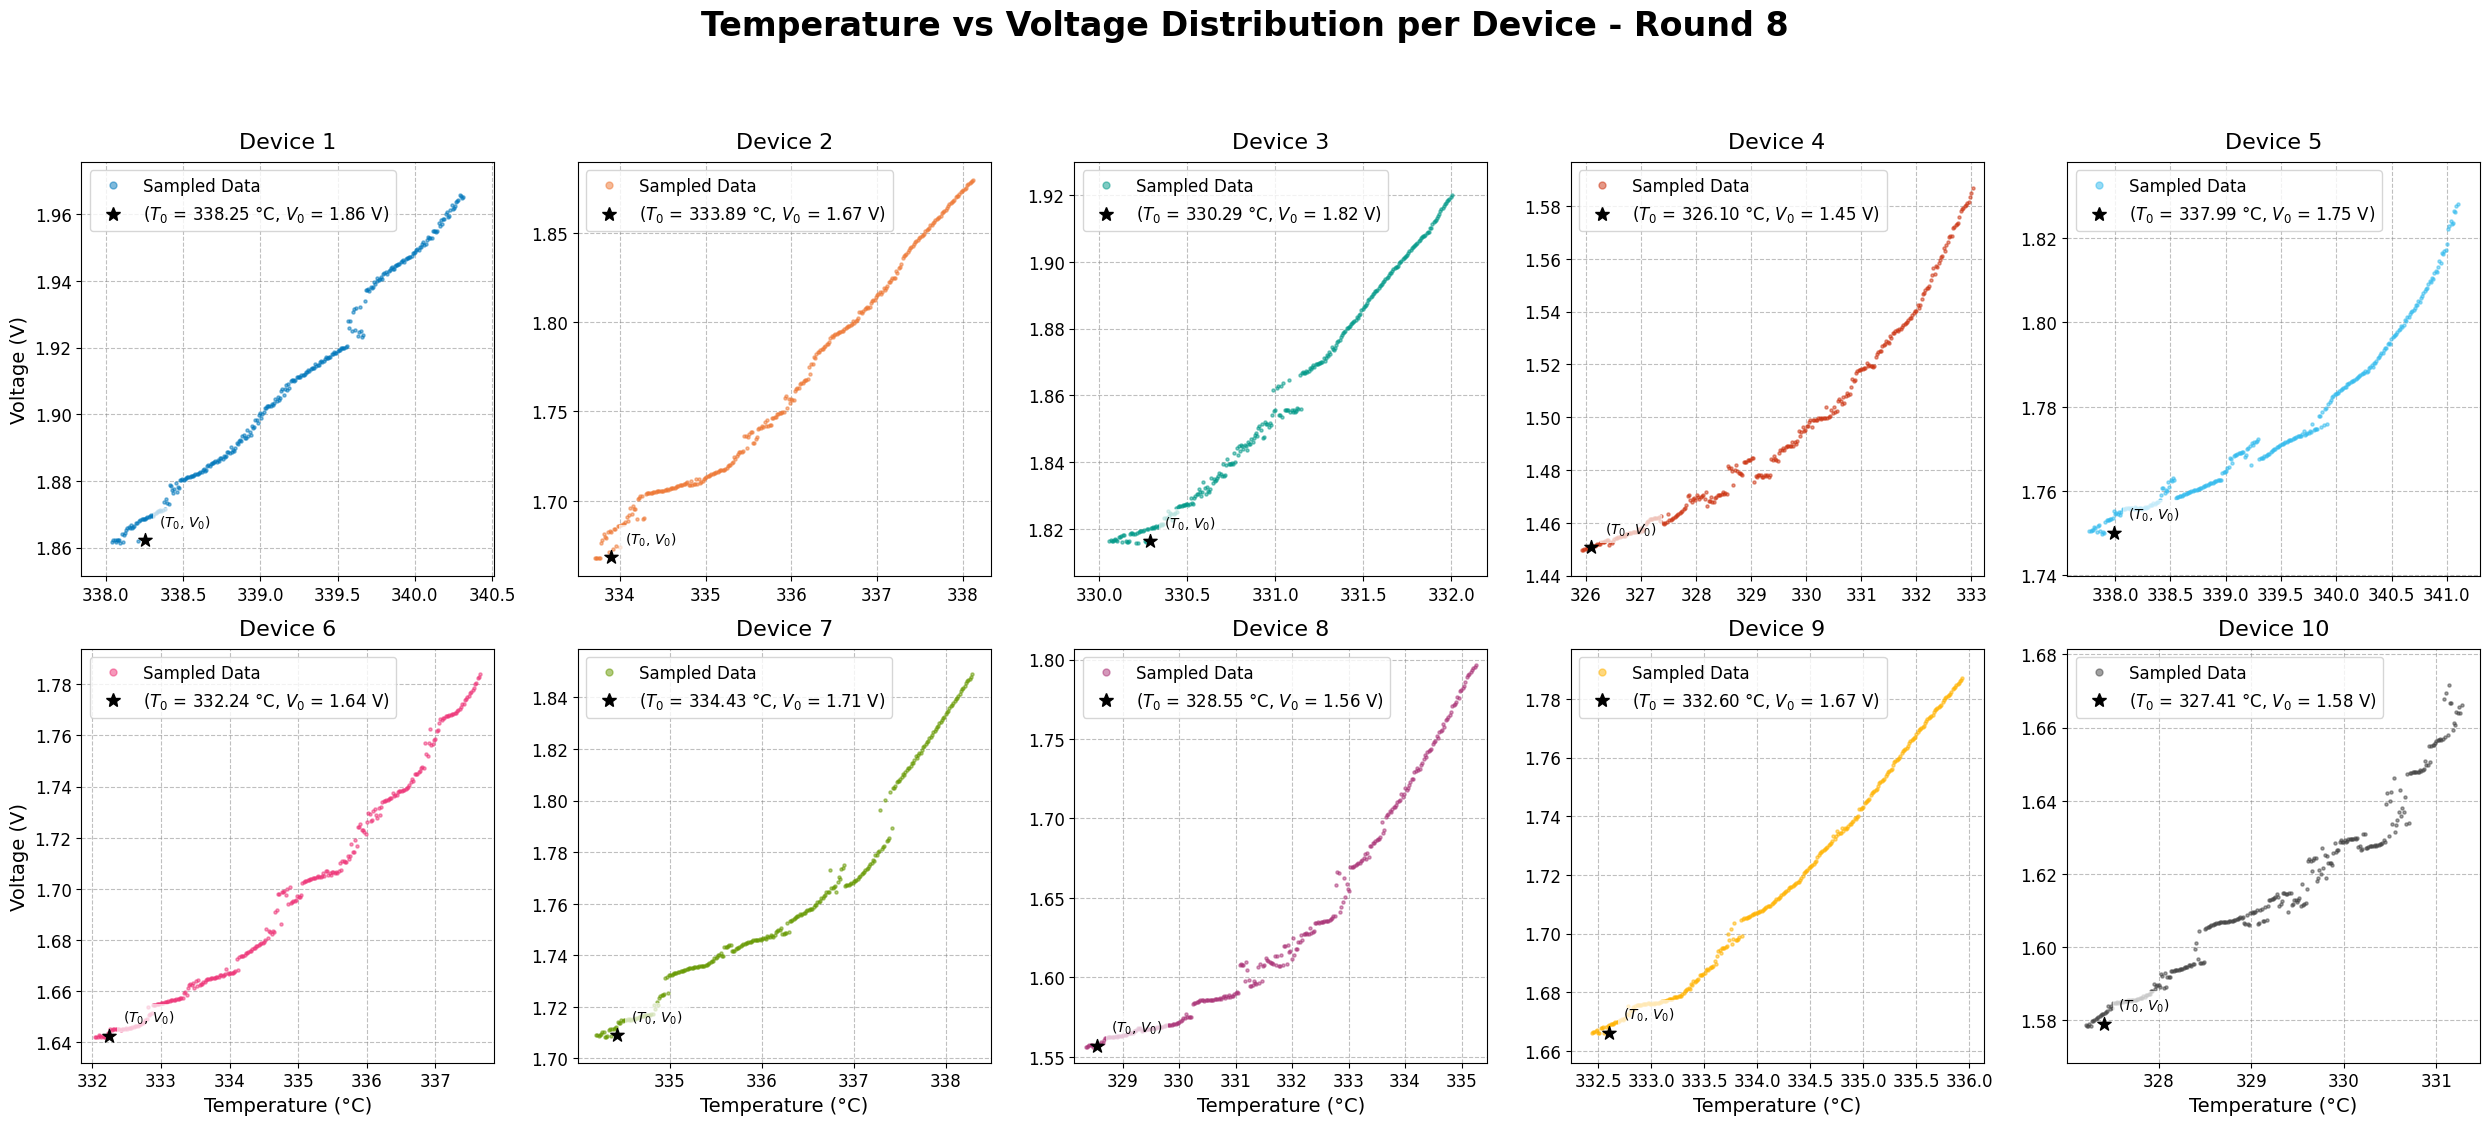

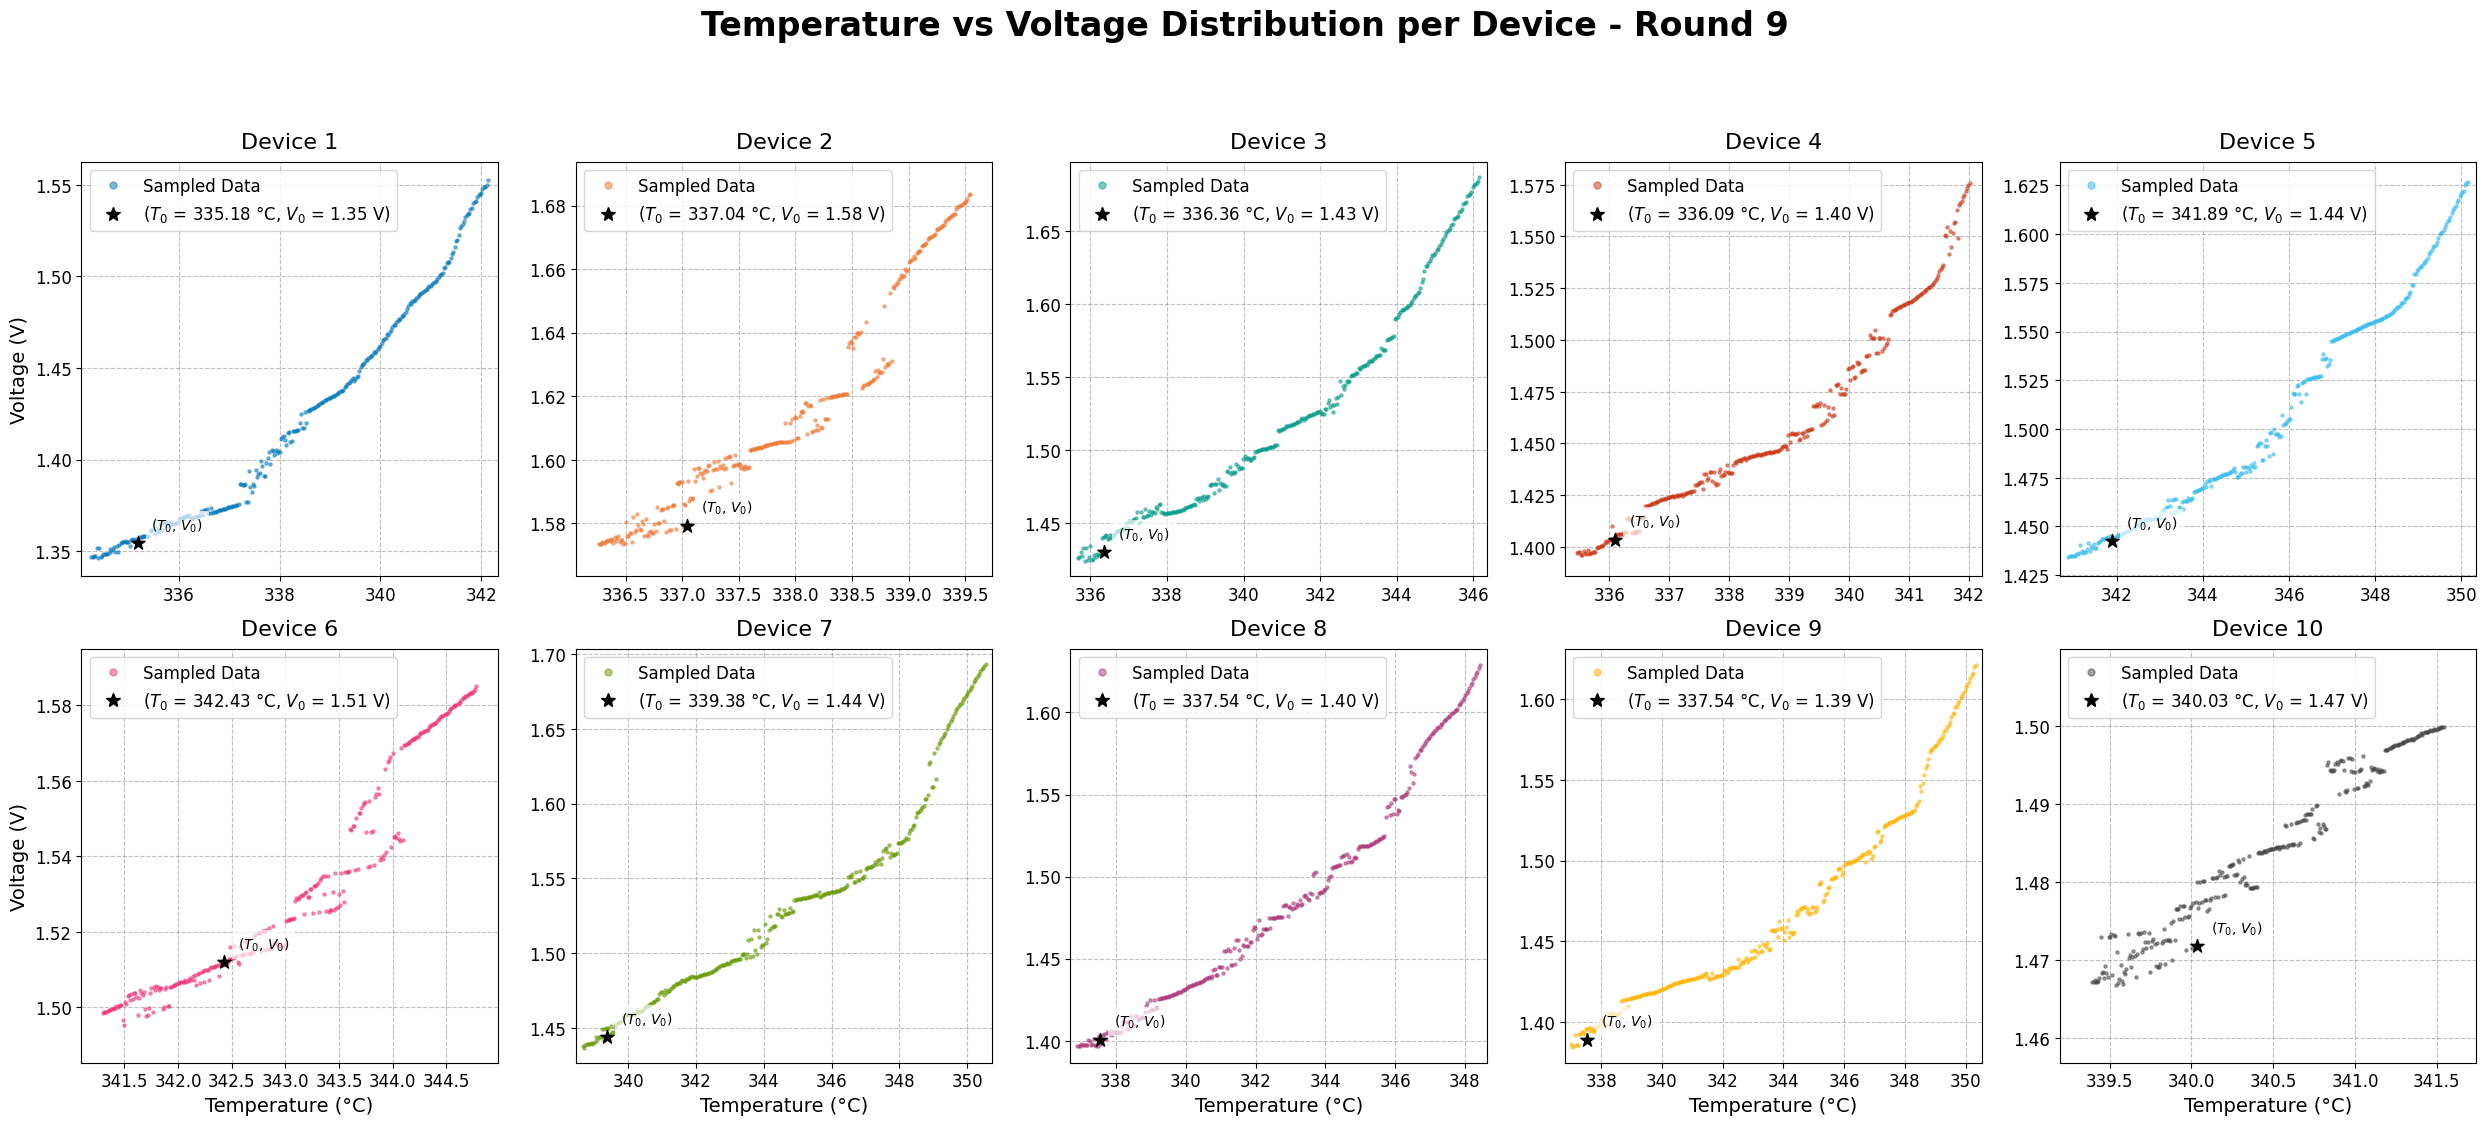

In [8]:
def plot_data_comparison(m_average_data, X, y, round_number=8, show_original=True):
    """
    Plot temperature vs voltage data showing both original and sampled data.
    
    Parameters:
    - m_average_data: Original nested dictionary {round: {device: [DataFrame]}}
    - X: DataFrame with features including temperature data
    - y: Series with voltage data
    - round_number: Round number to plot (default=8)
    - show_original: Boolean to control if original data should be plotted (default=True)
    """
    from matplotlib.lines import Line2D
    import pandas as pd
    import numpy as np
    
    # Create figure with subplots and space for legend at bottom
    fig = plt.figure(figsize=(25, 12), facecolor='white')
    
    # Create GridSpec to make space for legend
    gs = plt.GridSpec(3, 5, height_ratios=[1, 1, 0.2])
    
    # Define colors
    colors = ['#0077BB', '#EE7733', '#009988', '#CC3311', '#33BBEE', 
              '#EE3377', '#669900', '#AA3377', '#FFB300', '#444444']
    
    # Ensure round_number exists in the data
    if round_number not in m_average_data:
        raise ValueError(f"Round number {round_number} not found in m_average_data")
    
    # Create and populate subplots
    axs = []
    for i in range(10):
        ax = fig.add_subplot(gs[i // 5, i % 5])
        axs.append(ax)
        
        device_num = i + 1  # Devices are numbered 1-10
        
        try:
            original_df = m_average_data[round_number][device_num]
        except KeyError:
            print(f"Warning: No original data found for device {device_num} in round {round_number}")
            original_df = pd.DataFrame(columns=['min_temperature', 'end_voltage'])
        
        # Plot original data in grey if show_original is True
        if show_original and not original_df.empty:
            ax.scatter(original_df['min_temperature'],
                      original_df['end_voltage'],
                      color='grey',
                      alpha=0.2,
                      s=10,
                      marker='.',
                      zorder=1,
                      label='Original Data')
        
        # Create device mask more safely
        try:
            if 'round' in X.columns:
                device_mask = (X['round'] == round_number) & (X['device'] == device_num)
            else:
                # Assuming round_dict is available in the global scope
                device_mask = round_dict[round_number]['device'] == device_num
        except Exception as e:
            print(f"Warning: Error creating device mask for device {device_num}: {str(e)}")
            device_mask = pd.Series(False, index=X.index)
        
        # Check if we have any data for this device
        if not device_mask.any():
            print(f"Warning: No sampled data found for device {device_num} in round {round_number}")
            ax.text(0.5, 0.5, 'No data available', 
                   horizontalalignment='center',
                   verticalalignment='center',
                   transform=ax.transAxes)
            continue
        
        # Create device_data DataFrame safely
        try:
            device_data = pd.DataFrame({
                'min_temperature': X.loc[device_mask, 'min_temperature'],
                'end_voltage': y[device_mask],
                'init_end_voltage': X.loc[device_mask, 'init_end_voltage'],
                'init_min_temperature': X.loc[device_mask, 'init_min_temperature']
            })
            
            if device_data.empty:
                print(f"Warning: Empty device data for device {device_num}")
                continue
                
            device_data = device_data.sort_values('min_temperature')
            v0 = device_data['init_end_voltage'].iloc[0]
            t0 = device_data['init_min_temperature'].iloc[0]
            
            # Plot sampled data points
            scatter = ax.scatter(device_data['min_temperature'],
                               device_data['end_voltage'],
                               label='Sampled Data',
                               color=colors[i],
                               alpha=0.5,
                               s=20,
                               marker='.',
                               zorder=2)
            
            # Plot initial point (T₀, V₀)
            ax.scatter(t0, v0, 
                      color='black',
                      s=100,
                      marker='*',
                      label=f'($T_0$, $V_0$)',
                      zorder=3)
            
            # Add text annotation for the point
            ax.annotate(f'($T_0$, $V_0$)', 
                       xy=(t0, v0),
                       xytext=(10, 10),
                       textcoords='offset points',
                       fontsize=10,
                       bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
            
        except Exception as e:
            print(f"Error plotting device {device_num}: {str(e)}")
            continue
        
        # Customize subplot
        ax.set_title(f'Device {device_num}', fontsize=16, pad=10)
        ax.grid(True, linestyle='--', alpha=0.5, color='gray')
        ax.tick_params(axis='both', labelsize=12)
        
        # Set axis limits using available data
        if not device_data.empty:
            x_min = device_data['min_temperature'].min() - 0.2
            x_max = device_data['min_temperature'].max() + 0.2
            y_min = device_data['end_voltage'].min() - 0.01
            y_max = device_data['end_voltage'].max() + 0.01
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)
        
        # Add axis labels
        if i >= 5:
            ax.set_xlabel('Temperature (°C)', fontsize=14)
        if i % 5 == 0:
            ax.set_ylabel('Voltage (V)', fontsize=14)
        
        # Add legend only if we have data
        if not device_data.empty:
            legend_elements = []
            if show_original and not original_df.empty:
                legend_elements.append(
                    Line2D([0], [0], color='grey', marker='.', linestyle='None',
                           label='Original Data', alpha=0.2, markersize=10))
            legend_elements.extend([
                Line2D([0], [0], color=colors[i], marker='.', linestyle='None',
                       label='Sampled Data', alpha=0.5, markersize=10),
                Line2D([0], [0], color='black', marker='*', linestyle='None',
                       label=f'($T_0$ = {t0:.2f} °C, $V_0$ = {v0:.2f} V)', 
                       markersize=10)
            ])
            ax.legend(handles=legend_elements, loc='upper left', fontsize=12)
    
    # Add title
    fig.suptitle(f'Temperature vs Voltage Distribution per Device - Round {round_number}',
                 fontsize=24, fontweight='bold', y=1.02)
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# Plot for round 8
round_8_data = combined_df[combined_df['round'] == 8]
plot_data_comparison(with_initial_values , 
                    round_8_data[['min_temperature', 'init_min_temperature', 'init_end_voltage', 'round', 'device']], 
                    round_8_data['end_voltage'], 
                    round_number=8, 
                    show_original=False)

# Plot for round 9
round_9_data = combined_df[combined_df['round'] == 9]
plot_data_comparison(with_initial_values, 
                    round_9_data[['min_temperature', 'init_min_temperature', 'init_end_voltage', 'round', 'device']], 
                    round_9_data['end_voltage'], 
                    round_number=9, 
                    show_original=False)



In [10]:
import os
import pickle
import uuid

# Define the custom output directory for temporary files
custom_output_directory = os.path.abspath("my_custom_output_directory")

# Ensure the temporary directory exists
if not os.path.exists(custom_output_directory):
    os.makedirs(custom_output_directory)

# Define the results directory for saving the final model
results_directory = os.path.abspath("Results")

# Ensure the results directory exists
if not os.path.exists(results_directory):
    os.makedirs(results_directory)

# Generate a unique Hall of Fame file name to avoid conflicts
hall_of_fame_file = os.path.join(custom_output_directory, f"halloffame_{uuid.uuid4().hex}.csv")

# Test if the temporary file can be created
try:
    with open(hall_of_fame_file, "w") as f:
        f.write("Testing write access.\n")
    print(f"Successfully created test file: {hall_of_fame_file}")
except PermissionError:
    raise PermissionError(f"Cannot write to the specified directory: {custom_output_directory}")

Successfully created test file: c:\Users\Master_Student\ml\MyCode\my_custom_output_directory\halloffame_d7e15566f5354877a4a1e8fdd42cb3a8.csv


In [11]:
X = combined_df[['min_temperature', 'init_min_temperature', 'init_end_voltage', ]]

X = X.rename(columns={
    'min_temperature': 'T',
    'init_min_temperature': 'T_0',
    'init_end_voltage': 'V_0', 
   })

In [13]:
import os
import pickle
from pysr import PySRRegressor

Time_in_hours = 1/60

# Prepare the data for the current round
X = combined_df[['min_temperature', 'init_min_temperature', 'init_end_voltage']]

# Create target vector y
y = combined_df['end_voltage']

# Rename the column in y
y = y.rename("V")

# Rename columns in X
X = X.rename(columns={
    'min_temperature': 'T',
    'init_min_temperature': 'T_0',
    'init_end_voltage': 'V_0'
   })

# Initialize PySRRegressor
model = PySRRegressor(
    niterations=15_000,
    timeout_in_seconds= 60*60*Time_in_hours, # notera att det körs två rundor
    elementwise_loss="L2DistLoss()",
    warm_start=True,
    binary_operators=["+", "*", "-", "/", ],
    unary_operators=["exp", "log", "square", "cube", "pow_4(x) = x^4",],
    constraints={'*': (3, 3)}, # "^": (-1, 1)
    nested_constraints={"exp": { "exp": 0, "log": 0, "square": 0, "cube": 0, "pow_4" :0 }, 
                        "log": {"log": 0, "exp": 0},
                        "square": {"square": 0, "cube": 0, "pow_4":0 , "exp" :0 },
                        "cube": {"square": 0, "cube": 0, "pow_4":0 , "exp" :0 },
                        "pow_4": {"square": 0, "cube": 0, "pow_4":0 , "exp" :0 }
                        },
       extra_sympy_mappings={
        "pow_4": lambda x: x**4,
    },
    progress=False,
    bumper=True,
    population_size=75,
    tournament_selection_n=23,
    tournament_selection_p=0.8,
    ncycles_per_iteration=100,
    parsimony=1e-3,
    fraction_replaced_hof=0.08,
    optimizer_iterations=25,
    crossover_probability=0.12,
    weight_optimize=0.06,
    populations=50,
    adaptive_parsimony_scaling=100.0,
    tempdir=custom_output_directory,
    equation_file=hall_of_fame_file,

)

# Fit the model for the current round
model.fit(X, y)

# Save the model to the `results` directory using pickle
results_model_file = os.path.join(results_directory, f"V_vs_T_2.pkl")
with open(results_model_file, "wb") as f:
    pickle.dump(model, f)
print(f"Model saved in results folder: {results_model_file}")

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 0.000e+00
Head worker occupation: 0.0%
Progress: 0 / 750000 total iterations (0.000%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 9.480e+01
Head worker occupation: 71.3%. This is high, and will prevent efficient resource usage. Increase `ncycles_per_iteration` to reduce load on head worker.
Progress: 13 / 750000 total iterations (0.002%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
2           1.630e-01  7.971e+00  y = log(3.4488)
3           2.993e-03  3.997e+00  y = V_0 * 1.0357
4           2.880e-03  3.852e-02  y = V_0 + log(1.0585)
7           2

c:\Users\Master_Student\ml\my_env\Lib\site-packages\pysr\sr.py:1124: UserWarning: `extra_sympy_mappings` cannot be pickled and will be removed from the serialized instance. When loading the model, please redefine `extra_sympy_mappings` at runtime.
  warnings.warn(


Model saved in results folder: c:\Users\Master_Student\ml\MyCode\Results\V_vs_T_2.pkl


In [14]:
print(model.equations['equation'])

equations = model.equations['equation']

for i, eq in enumerate(equations):
    print(f"Equation {i}:")
    print(eq)
    print("-" * 50)  # Separator for better readability

c:\Users\Master_Student\ml\my_env\Lib\site-packages\pysr\sr.py:1172: FutureWarning: PySRRegressor.equations is now deprecated. Please use PySRRegressor.equations_ instead.
  warnings.warn(


0                                    square(1.2701163)
1                                    V_0 + 0.056865275
2                                 T / (325.8467 / V_0)
3                       T / (T_0 / (0.04521686 + V_0))
4          (T - 13.57539) / (T_0 / (0.11228353 + V_0))
5    (T / (T_0 / (square(1.7919415) + V_0))) + -3.1...
6    (T / ((T_0 - 16.767363) / (V_0 + 4.6484413))) ...
7          T / ((T_0 + ((T_0 - T) * cube(V_0))) / V_0)
8    T / (((T_0 + ((T_0 - T) * cube(V_0))) / V_0) +...
Name: equation, dtype: object
Equation 0:
square(1.2701163)
--------------------------------------------------
Equation 1:
V_0 + 0.056865275
--------------------------------------------------
Equation 2:
T / (325.8467 / V_0)
--------------------------------------------------
Equation 3:
T / (T_0 / (0.04521686 + V_0))
--------------------------------------------------
Equation 4:
(T - 13.57539) / (T_0 / (0.11228353 + V_0))
--------------------------------------------------
Equation 5:
(T / (T_0 / (squ

In [15]:
# Prepare the data for all rounds
X = combined_df_unsampled[['min_temperature', 'init_min_temperature', 'init_end_voltage', 'round', 'device']].rename(
    columns={'min_temperature': 'T', 'init_min_temperature': 'T_0', 'init_end_voltage': 'V_0'}
)
y = combined_df_unsampled['end_voltage']

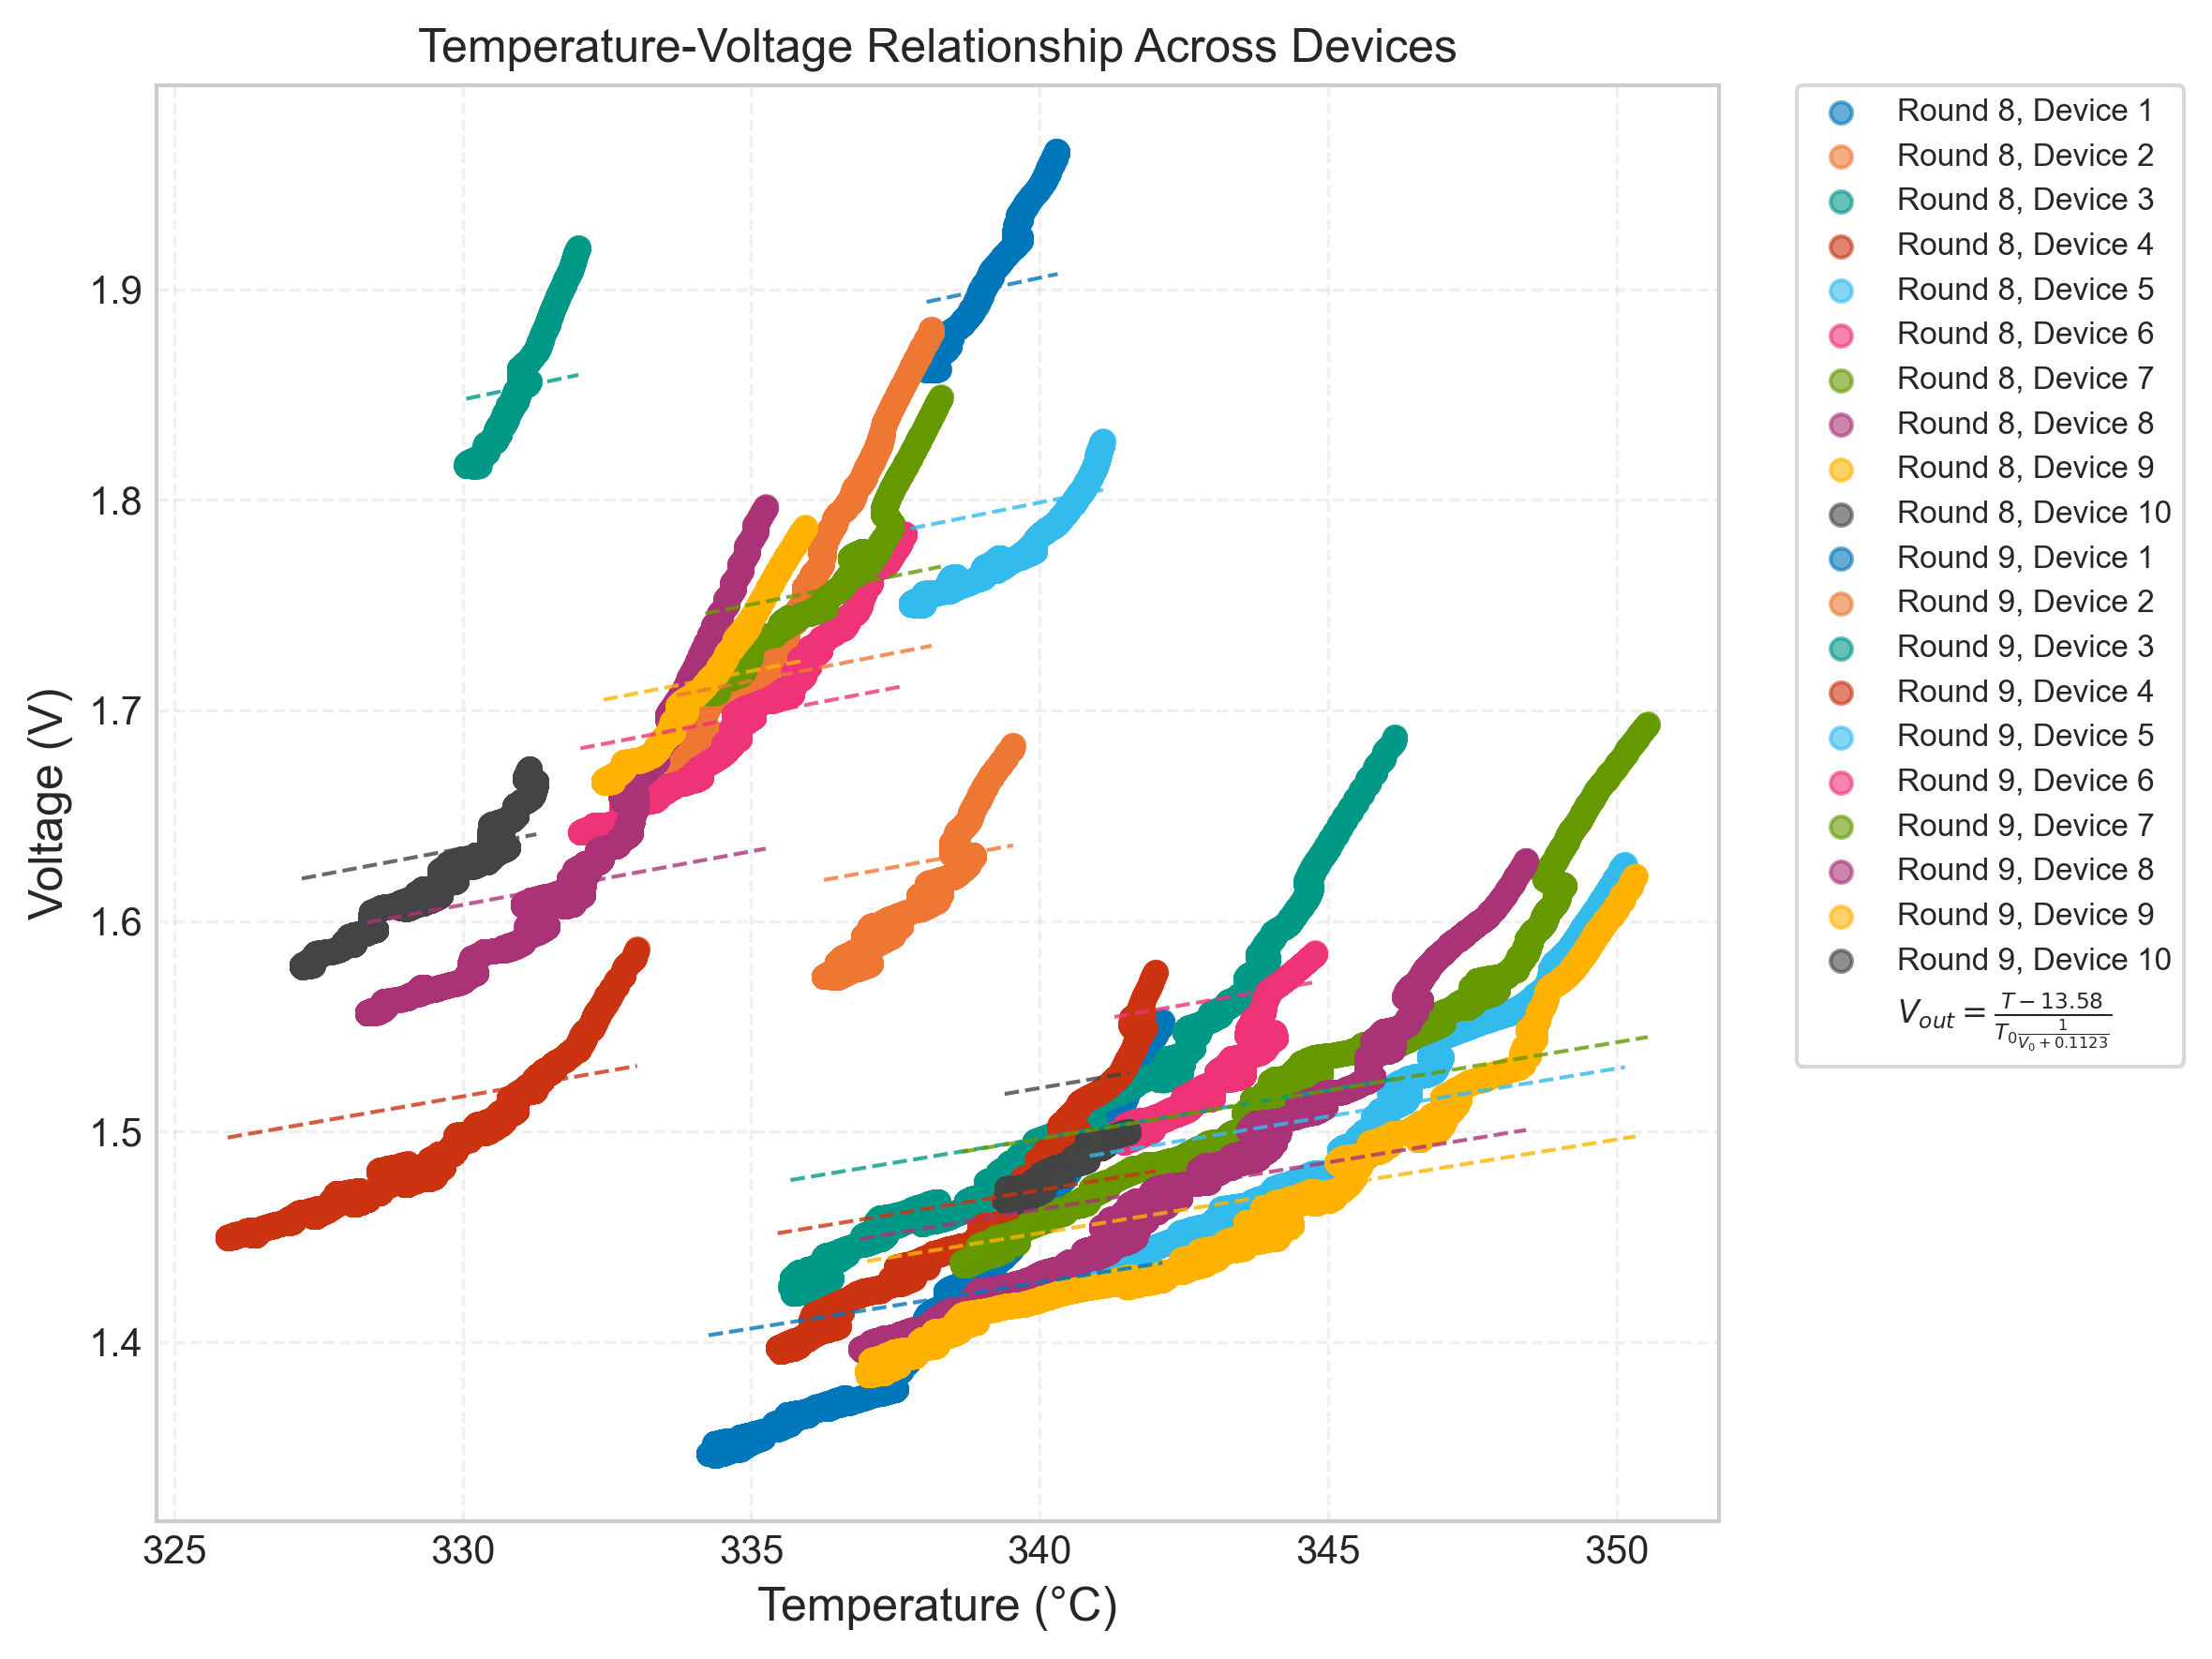

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

def plot_combined_regression_comparison(X, y, model, eq_index=0, save_path=None):
    """
    Create publication-quality plot of temperature vs voltage data with predictions.
    
    Parameters:
    - X: DataFrame with features ('T', 'T_0', 'V_0')
    - y: Series with voltage data
    - model: PySR model for predictions
    - eq_index: Index of equation for LaTeX representation
    - save_path: Optional path to save figure
    """
    # Set publication-quality style parameters
    plt.style.use('seaborn-v0_8-whitegrid')
    mpl.rcParams.update({
        'font.family': 'Arial',
        'font.size': 10,
        'axes.labelsize': 12,
        'axes.titlesize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 8,
        'figure.dpi': 300
    })

    
    # Create figure with appropriate dimensions for publication
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Professional color scheme
    colors = ['#0077BB', '#EE7733', '#009988', '#CC3311', '#33BBEE',
              '#EE3377', '#669900', '#AA3377', '#FFB300', '#444444']
    
    # Generate predictions
    y_pred = model.predict(X, eq_index)
    
    for round_number in [8, 9]:
        round_mask = (X['round'] == round_number)
        X_round = X[round_mask]
        y_round = y[round_mask]
        y_pred_round = y_pred[round_mask]
        
        for device_num in range(1, 11):
            device_mask = (X_round['device'] == device_num)
            
            if not device_mask.any():
                continue
            
            device_data = pd.DataFrame({
                'T': X_round.loc[device_mask, 'T'],
                'V': y_round[device_mask],
                'predicted_voltage': y_pred_round[device_mask]
            }).sort_values('T')
            
            # Plot with professional styling
            ax.scatter(device_data['T'], device_data['V'],
                      color=colors[device_num-1], alpha=0.6, s=30,
                      label=f'Round {round_number}, Device {device_num}')
            
            ax.plot(device_data['T'], device_data['predicted_voltage'],
                   linestyle='--', color=colors[device_num-1], alpha=0.8,
                   linewidth=1)

    # Add equation with professional formatting
    expr_latex = model.latex(eq_index, 4)
    ax.plot([], [], ' ', label=f'$V_{{out}} = {expr_latex}$')
    
    # Customize axes and labels
    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel('Voltage (V)')
    ax.set_title('Temperature-Voltage Relationship Across Devices')
    
    # Improve grid appearance
    ax.grid(True, linestyle='--', alpha=0.3, which='major')
    ax.grid(True, linestyle=':', alpha=0.1, which='minor')
    
    # Format legend professionally
    legend = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
                      borderaxespad=0., ncol=1, frameon=True)
    legend.get_frame().set_alpha(0.9)
    legend.get_frame().set_edgecolor('lightgray')
    
    # Adjust layout to prevent cutoff
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    return fig, ax

fig, ax = plot_combined_regression_comparison(X, y, model, eq_index=4, save_path='regression_plot.png')